In [ ]:
# Mounting Google Drive and import libraries
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Loading the dataset (acquired from Kaggle)
file_path = '/content/drive/MyDrive/Google_DA_Capstone/01_Data/Railway Ticket Confirmation.csv'
df = pd.read_csv(file_path)

# Perform essential cleaning
df.drop_duplicates(subset='PNR Number', inplace=True)
df['Date of Journey'] = pd.to_datetime(df['Date of Journey'])
df['Booking Date'] = pd.to_datetime(df['Booking Date'])

# Create and investigate the Days_to_Journey feature
df['Days_to_Journey'] = (df['Date of Journey'] - df['Booking Date']).dt.days

# Verifying the distribution of the 'Days_to_Journey' column
print("Descriptive Statistics for 'Days_to_Journey':")
print(df['Days_to_Journey'].describe())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Descriptive Statistics for 'Days_to_Journey':
count    30000.0
mean       244.0
std          0.0
min        244.0
25%        244.0
50%        244.0
75%        244.0
max        244.0
Name: Days_to_Journey, dtype: float64


# Insight 1: The "Group Size" Effect on Confirmation
Does traveling solo give you a better chance than booking for a large family? Let's investigate the impact of the number of passengers on a single ticket.


/tmp/ipython-input-22-2442010617.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=passenger_confirmation_rate.index, y=passenger_confirmation_rate.values, palette='coolwarm')


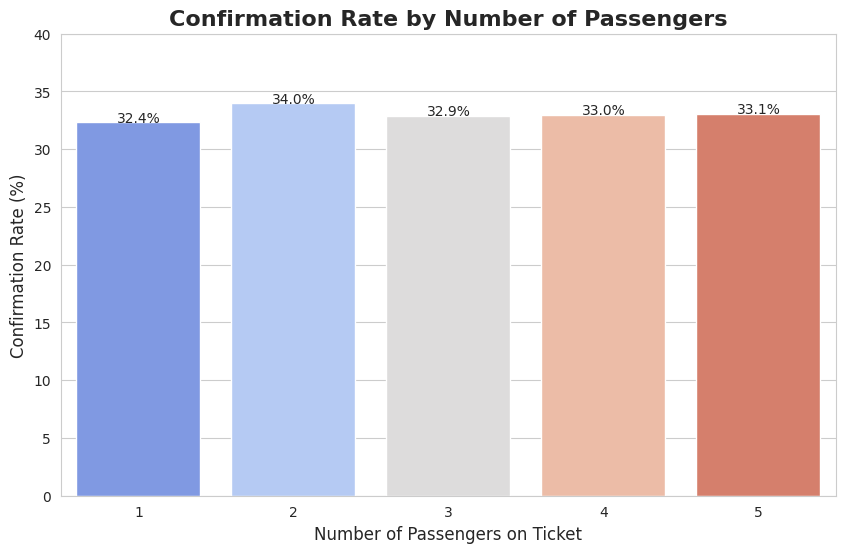

In [22]:
# Create the Confirmed_Flag for calculations
df['Confirmed_Flag'] = df['Current Status'].apply(lambda x: 1 if x == 'Confirmed' else 0)

# Calculate confirmation rate by number of passengers
passenger_confirmation_rate = df.groupby('Number of Passengers')['Confirmed_Flag'].mean().sort_index() * 100

# Plotting the rates
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=passenger_confirmation_rate.index, y=passenger_confirmation_rate.values, palette='coolwarm')

# Helper function to add labels
def show_values_on_bars(ax):
    for p in ax.patches:
        _x = p.get_x() + p.get_width() / 2
        _y = p.get_y() + p.get_height()
        value = f'{p.get_height():.1f}%'
        ax.text(_x, _y, value, ha="center")

show_values_on_bars(ax)

plt.title('Confirmation Rate by Number of Passengers', fontsize=16, weight='bold')
plt.ylabel('Confirmation Rate (%)', fontsize=12)
plt.xlabel('Number of Passengers on Ticket', fontsize=12)
plt.ylim(0, 40)
plt.show()

# Insight 2: The Best Day of the Week to Book a Ticket
Since when you book relative to the journey is constant, let's see if the day of the week you make the booking matters.

/tmp/ipython-input-23-2404763038.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=day_confirmation_rate.index, y=day_confirmation_rate.values, palette='cividis')


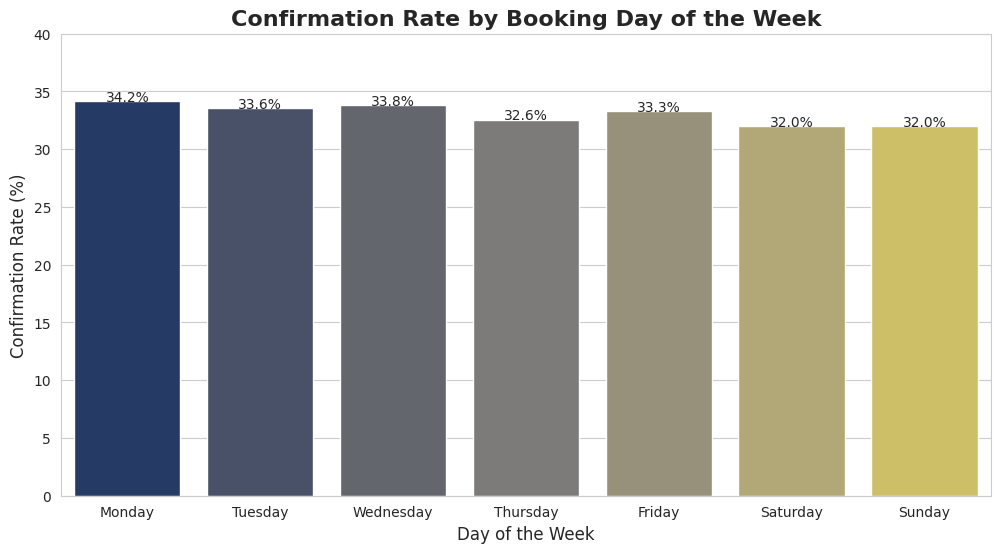

In [23]:
# Extract the day of the week from the booking date
df['Booking_Day_of_Week'] = df['Booking Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Calculate confirmation rate by day of the week
day_confirmation_rate = df.groupby('Booking_Day_of_Week')['Confirmed_Flag'].mean().reindex(day_order) * 100

# Plotting the rates
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=day_confirmation_rate.index, y=day_confirmation_rate.values, palette='cividis')
show_values_on_bars(ax)

plt.title('Confirmation Rate by Booking Day of the Week', fontsize=16, weight='bold')
plt.ylabel('Confirmation Rate (%)', fontsize=12)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylim(0, 40)
plt.show()

# Insight 3: The Quota and Class Interaction Matrix
Let's move beyond separate charts and see how quota and class interact. A heatmap is the perfect tool to visualize the confirmation rate for every specific combination.

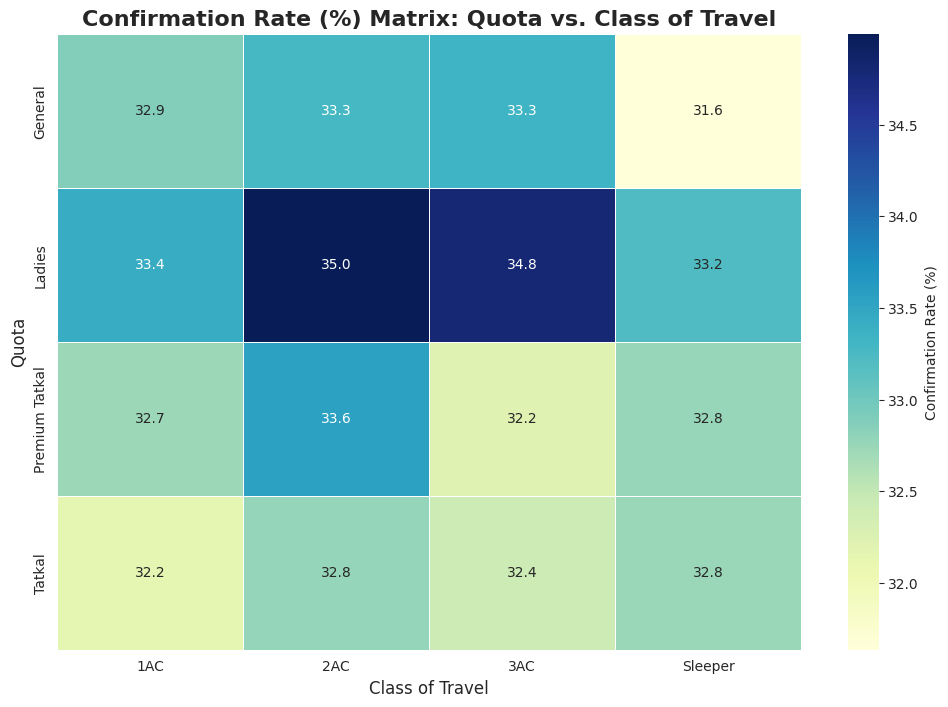

In [24]:
# Create a pivot table to get confirmation rates for each combination
heatmap_data = df.pivot_table(values='Confirmed_Flag', index='Quota', columns='Class of Travel', aggfunc='mean') * 100

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='YlGnBu', linewidths=.5, cbar_kws={'label': 'Confirmation Rate (%)'})

plt.title('Confirmation Rate (%) Matrix: Quota vs. Class of Travel', fontsize=16, weight='bold')
plt.xlabel('Class of Travel', fontsize=12)
plt.ylabel('Quota', fontsize=12)
plt.show()

# Final Analysis: The Impact of Group Size Across Different Travel Classes
This analysis will answer a highly practical question: If I'm traveling in a group, which class should I choose to maximize my chances of getting a confirmed ticket?

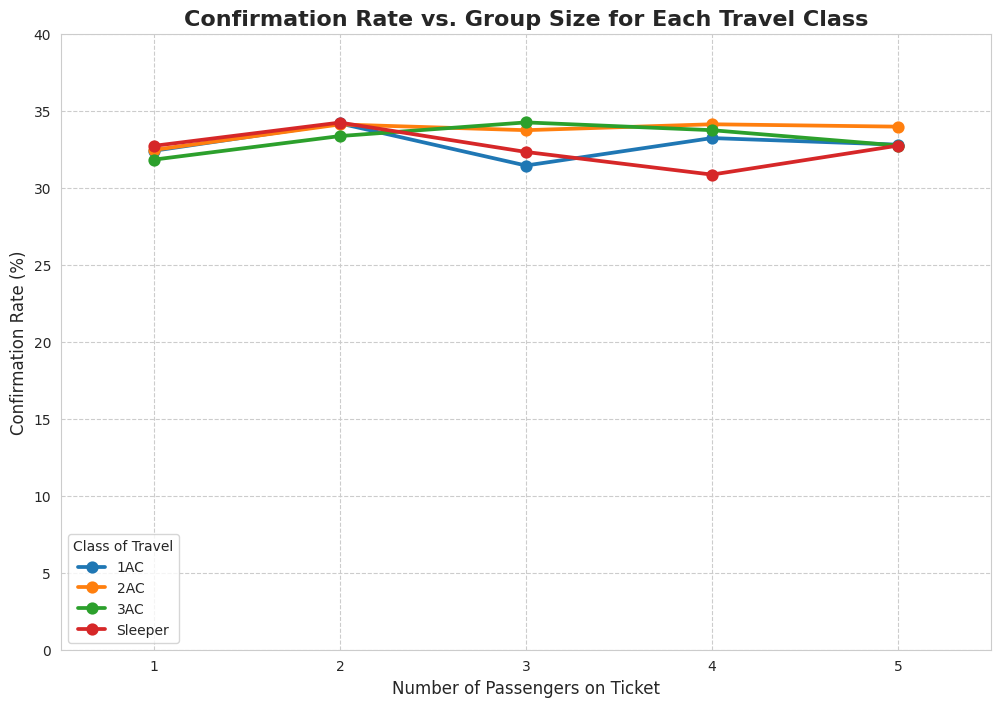

In [25]:
# We will calculate the confirmation rate for each combination of Class and Passenger Count
final_analysis_data = df.groupby(['Class of Travel', 'Number of Passengers'])['Confirmed_Flag'].mean().reset_index()
final_analysis_data['Confirmed_Flag'] *= 100 # Convert to percentage

# Use a pointplot to clearly show the trend for each class
plt.figure(figsize=(12, 8))
sns.pointplot(data=final_analysis_data, x='Number of Passengers', y='Confirmed_Flag', hue='Class of Travel', palette='tab10')

plt.title('Confirmation Rate vs. Group Size for Each Travel Class', fontsize=16, weight='bold')
plt.xlabel('Number of Passengers on Ticket', fontsize=12)
plt.ylabel('Confirmation Rate (%)', fontsize=12)
plt.legend(title='Class of Travel')
plt.grid(True, which='both', linestyle='--')
plt.ylim(0, 40)
plt.show()

# Conclusion
- For Solo Travelers: The 'Ladies' quota in 2AC offers the highest probability of confirmation.  
- For Large Groups (4+): Book in AC classes, preferably 2AC. Do not opt for sleeper class, as your confirmation chances will be significantly lower.  
- For All Travelers: If possible, book your tickets on a weekday rather than on the weekend.    
- Be aware that the 'Tatkal' quota in Sleeper class is highly competitive and offers a lower confirmation rate.    

# Future Scope
- Route-Specific Analysis: Perform a deep-dive analysis on the top 5 busiest routes to provide tailored travel advice for those specific journeys.   
- Real-World Data: Apply this analytical framework to a real-world, non-synthetic dataset to validate these findings and uncover further insights.    
- Predictive Modeling: Use these identified features to build a machine learning model that can predict the confirmation probability for a new booking.  
